In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1,l1_l2,l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import he_uniform,he_normal
from sklearn.utils import class_weight
from shutil import copy2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels

# from vis.utils import utils
from tensorflow.keras import activations 
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

### Preprocessing

In [2]:
# num_classes = 15
# img_rows, img_cols = 64,64
# batch_size =32
# rescale=1./255
# # home/kashraf/fall2021_cours
# train_data_dir ="/home/kashraf/fall2021_coursework/Neural Nets/train_validation/train"
# validation_data_dir = "/home/kashraf/fall2021_coursework/Neural Nets/train_validation/validation"

# # Let's use some data augmentaiton 
# train_datagen = ImageDataGenerator(
#       rotation_range = 30,    
#       width_shift_range = 0.3,      
#       height_shift_range = 0.3,
#       horizontal_flip=True,
#       vertical_flip=True,
#       rescale=rescale)
# validation_datagen = ImageDataGenerator(rescale=rescale)
 
# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(img_rows, img_cols),
#     color_mode="grayscale",
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=True)

# validation_generator = validation_datagen.flow_from_directory(
#     validation_data_dir,
#     target_size=(img_rows, img_cols),
#     color_mode="grayscale",
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False)


In [3]:
num_classes = 15
img_rows, img_cols = 64,64
batch_size =32
# rescale=1./255
# home/kashraf/fall2021_cours
train_data_dir ="/home/kashraf/fall2021_coursework/Neural Nets/train_validation/train"
validation_data_dir = "/home/kashraf/fall2021_coursework/Neural Nets/train_validation/validation"

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      
      horizontal_flip=True,
      vertical_flip=True,
      )
validation_datagen = ImageDataGenerator()
 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 4458 images belonging to 15 classes.
Found 1362 images belonging to 15 classes.


In [5]:
model = Sequential()

# First CONV-ReLU Layer
model.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (img_rows, img_cols,1),kernel_regularizer=l2(0.38),
                 kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

# Second CONV-ReLU Layer
model.add(Conv2D(64, (5, 5), padding = "same",kernel_regularizer=l2(0.38),kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.35))

# Second CONV-ReLU Layer
model.add(Conv2D(128, (7, 7), padding = "same",kernel_regularizer=l2(0.38),kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))

## 3rd conv-pool layer
model.add(Conv2D(256, (3, 3), padding="same",kernel_regularizer=l2(0.38), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.35))

model.add(Flatten())

model.add(Dense(621))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))


# Final Dense Layer
model.add(Dense(num_classes,activation='softmax',name='Hafizzo'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)       

In [6]:
checkpoint = ModelCheckpoint("cnn_scene_SGDv2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = SGD(learning_rate=0.001),
              metrics = ['accuracy'])


epochs = 100
import time
time_start=time.perf_counter()

history= model.fit_generator(   
    
    train_generator,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator)
elapsed_time=time.perf_counter()-time_start



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
139/140 [============================>.] - ETA: 0s - loss: 331.2123 - accuracy: 0.1421
Epoch 00001: val_loss improved from inf to 296.24927, saving model to cnn_scene_SGDv2.h5
140/140 [==============================] - 3s 24ms/step - loss: 330.9683 - accuracy: 0.1418 - val_loss: 296.2493 - val_accuracy: 0.2320 - lr: 0.0010
Epoch 2/100
137/140 [============================>.] - ETA: 0s - loss: 268.2094 - accuracy: 0.1953
Epoch 00002: val_loss improved from 296.24927 to 241.01909, saving model to cnn_scene_SGDv2.h5
140/140 [==============================] - 3s 23ms/step - loss: 267.6212 - accuracy: 0.1963 - val_loss: 241.0191 - val_accuracy: 0.1256 - lr: 0.0010
Epoch 3/100
140/140 [==============================] - ETA: 0s - loss: 216.8613 - accuracy: 0.2322
Epoch 00003: val_loss improved from 241.01909 to 196.77905, saving model to cnn_scene_SGDv2.h5
140/140 [==============================] - 3s 22ms

Epoch 25/100
138/140 [============================>.] - ETA: 0s - loss: 3.6090 - accuracy: 0.6008
Epoch 00025: val_loss improved from 6.18693 to 6.08336, saving model to cnn_scene_SGDv2.h5
140/140 [==============================] - 3s 22ms/step - loss: 3.6048 - accuracy: 0.6012 - val_loss: 6.0834 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 26/100
140/140 [==============================] - ETA: 0s - loss: 3.2138 - accuracy: 0.6079
Epoch 00026: val_loss improved from 6.08336 to 5.77499, saving model to cnn_scene_SGDv2.h5
140/140 [==============================] - 3s 22ms/step - loss: 3.2138 - accuracy: 0.6079 - val_loss: 5.7750 - val_accuracy: 0.2357 - lr: 0.0010
Epoch 27/100
137/140 [============================>.] - ETA: 0s - loss: 2.9318 - accuracy: 0.5983
Epoch 00027: val_loss improved from 5.77499 to 2.86142, saving model to cnn_scene_SGDv2.h5
140/140 [==============================] - 3s 22ms/step - loss: 2.9247 - accuracy: 0.6003 - val_loss: 2.8614 - val_accuracy: 0.5822 - lr: 0.001

Epoch 51/100
140/140 [==============================] - ETA: 0s - loss: 1.1307 - accuracy: 0.7858
Epoch 00051: val_loss did not improve from 1.09039
140/140 [==============================] - 3s 22ms/step - loss: 1.1307 - accuracy: 0.7858 - val_loss: 1.1077 - val_accuracy: 0.8025 - lr: 8.0000e-06
Epoch 52/100
137/140 [============================>.] - ETA: 0s - loss: 1.1317 - accuracy: 0.7808
Epoch 00052: val_loss improved from 1.09039 to 1.01203, saving model to cnn_scene_SGDv2.h5
140/140 [==============================] - 3s 22ms/step - loss: 1.1295 - accuracy: 0.7813 - val_loss: 1.0120 - val_accuracy: 0.8363 - lr: 8.0000e-06
Epoch 53/100
138/140 [============================>.] - ETA: 0s - loss: 1.1486 - accuracy: 0.7749
Epoch 00053: val_loss did not improve from 1.01203
140/140 [==============================] - 3s 21ms/step - loss: 1.1478 - accuracy: 0.7755 - val_loss: 1.0166 - val_accuracy: 0.8304 - lr: 8.0000e-06
Epoch 54/100
139/140 [============================>.] - ETA: 0s - 

Epoch 77/100
138/140 [============================>.] - ETA: 0s - loss: 1.1194 - accuracy: 0.7856
Epoch 00077: val_loss did not improve from 1.00025
140/140 [==============================] - 3s 21ms/step - loss: 1.1187 - accuracy: 0.7853 - val_loss: 1.0110 - val_accuracy: 0.8311 - lr: 1.0240e-10
Epoch 78/100
139/140 [============================>.] - ETA: 0s - loss: 1.1141 - accuracy: 0.7804
Epoch 00078: val_loss did not improve from 1.00025
140/140 [==============================] - 3s 22ms/step - loss: 1.1131 - accuracy: 0.7802 - val_loss: 1.0149 - val_accuracy: 0.8304 - lr: 1.0240e-10
Epoch 79/100
139/140 [============================>.] - ETA: 0s - loss: 1.1257 - accuracy: 0.7784
Epoch 00079: val_loss did not improve from 1.00025

Epoch 00079: ReduceLROnPlateau reducing learning rate to 2.0480002416167767e-11.
140/140 [==============================] - 3s 22ms/step - loss: 1.1279 - accuracy: 0.7779 - val_loss: 1.0131 - val_accuracy: 0.8304 - lr: 1.0240e-10
Epoch 80/100
137/140 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


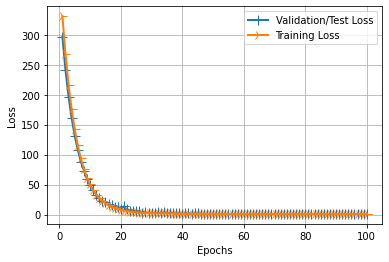

In [7]:
print(history.history.keys())
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('Loss.png', dpi = 1200)
plt.show()

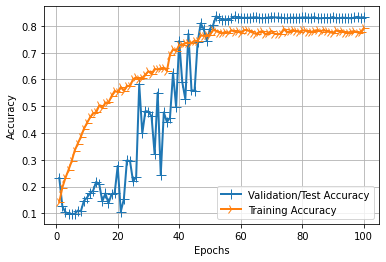

In [8]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('Accuracy.png', dpi = 1200)
plt.show()

In [10]:
elapsed_time

311.29226860497147

### Evaluation


 Classification report: 
               precision    recall  f1-score   support

     Bedroom       0.89      0.78      0.83       114
    Building       0.95      0.95      0.95       111
       Store       0.91      0.50      0.64       121
    Industry       0.86      0.77      0.81       122
 Living room       0.79      0.82      0.80       125
     Kitchen       0.79      0.78      0.78        77
     Highway       0.80      0.99      0.88        75
       Coast       1.00      0.77      0.87        77
      Office       0.77      0.92      0.84        79
    Mountain       0.90      0.89      0.89        79
 Inside city       0.67      0.94      0.78        77
      Forest       0.88      0.87      0.88        79
      Surbub       0.75      0.97      0.84        78
      Street       0.87      0.88      0.88        76
 Opencountry       0.77      0.88      0.82        72

    accuracy                           0.83      1362
   macro avg       0.84      0.85      0.83      1362

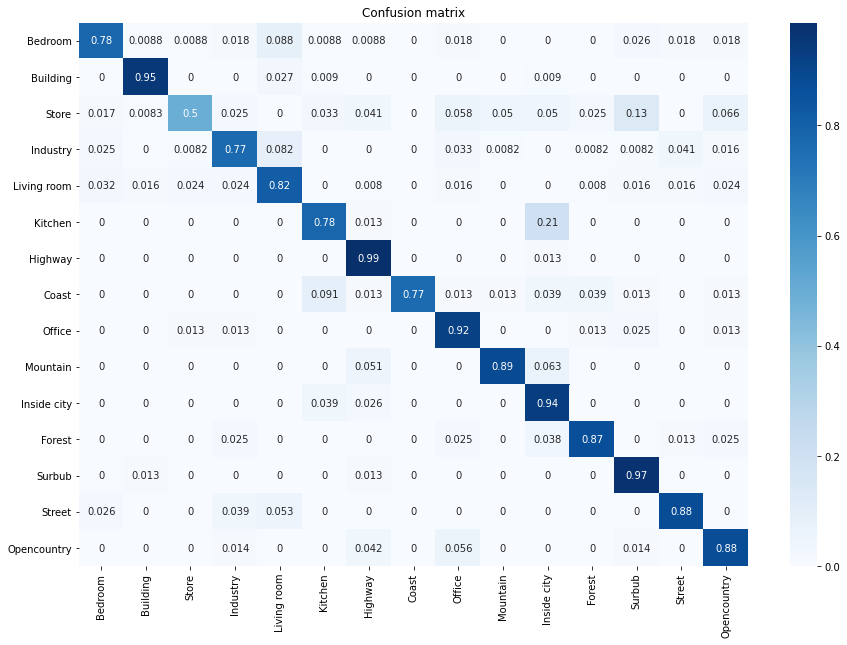

In [9]:
import seaborn as sr
import pandas as pd

y_pred=np.argmax(model.predict(validation_generator), axis=1)
y_test=validation_generator.classes


# y_predict,distances1=  face_recognition(x_test_recog,T_distance)
# accuracy=accuracy_score(y_test_recog,y_predict)
class_names=["Bedroom","Building","Store","Industry","Living room","Kitchen","Highway",'Coast',
             "Office","Mountain","Inside city","Forest","Surbub","Street","Opencountry"]
report=classification_report(y_test,y_pred,target_names=class_names)

conf=confusion_matrix(y_test,y_pred,normalize="true")
conf_df=pd.DataFrame(conf, index=class_names, columns=class_names)
# print("\nFace  accuracy =",accuracy)
print("\n Classification report: \n",report)
fig=plt.figure(figsize=(15,10))
sr.heatmap(conf_df,annot=True,cmap="Blues")
plt.title("Confusion matrix")
plt.show()

In [ ]:
len(validation_generator.classes)